# Спрос на авиарейсы во время фестивалей

Необходимо изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

Имеются следующие таблицы:

Таблица airports — информация об аэропортах:

* airport_code — трёхбуквенный код аэропорта
* airport_name — название аэропорта
* city — город
* timezone — временная зона

Таблица aircrafts — информация о самолётах:

* aircraft_code — код модели самолёта
* model — модель самолёта
* range — дальность полёта

Таблица tickets — информация о билетах:

* ticket_no — уникальный номер билета
* passenger_id — персональный идентификатор пассажира
* passenger_name — имя и фамилия пассажира

Таблица flights — информация о рейсах:

* flight_id — уникальный идентификатор рейса
* departure_airport — аэропорт вылета
* departure_time — дата и время вылета
* arrival_airport — аэропорт прилёта
* arrival_time — дата и время прилёта
* aircraft_code — id самолёта

Таблица ticket_flights — стыковая таблица «рейсы-билеты»

* ticket_no — номер билета
* flight_id — идентификатор рейса

Таблица festivals — информация о фестивалях

* festival_id — уникальный номер фестиваля
* festival_date — дата проведения фестиваля
* festival_city — город проведения фестиваля
* festival_name — название фестиваля

У нас есть файлы, в которых содержатся результаты запросов:

**query_1.csv** — результат первого запроса:

```SQL
SELECT 
    aircrafts.model, 
    COUNT(flights.flight_id) AS flights_amount 
FROM 
    aircrafts 
RIGHT JOIN 
    flights ON aircrafts.aircraft_code=flights.aircraft_code 
WHERE
    EXTRACT(MONTH FROM flights.departure_time ) = '09' AND EXTRACT(YEAR FROM flights.departure_time ) = '2018' 
GROUP BY 
    aircrafts.model
```

В нём содержится такая информация:

- *model* — модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроcа:

```SQL
SELECT
    city, 
    AVG(cnt_flights) AS average_flights 
FROM 
(
    SELECT 
        city, 
        COUNT(flights.flight_id) AS cnt_flights 
    FROM
        flights 
    INNER JOIN airports ON flights.arrival_airport = airports.airport_code 
    WHERE
        EXTRACT(MONTH FROM flights.arrival_time  ) = '08' AND EXTRACT(YEAR FROM flights.arrival_time) = '2018'
    GROUP BY
        city, 
        arrival_time::date
) AS sub_flight
GROUP BY 
    city
```

В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

**query_last.csv** — результат последнего запроса:

```SQL
SELECT 
	T.week_number,
	T.ticket_amount,
	T.festival_week,
	T.festival_name
FROM 
(
(
    SELECT
        EXTRACT (week FROM flights.departure_time) AS week_number,
        COUNT(ticket_flights.ticket_no)  AS ticket_amount
    FROM 
        flights 
    LEFT JOIN
        ticket_flights ON ticket_flights.flight_id = flights.flight_id 
    LEFT JOIN
        airports ON flights.arrival_airport = airports.airport_code
    WHERE
        airports.city = 'Москва'
        AND
        CAST(flights.arrival_time AS DATE) BETWEEN '2018-07-23' AND '2018-09-30'
    GROUP BY 
        week_number
) t
LEFT JOIN 
(
    SELECT 		
		festival_name,	
		EXTRACT(WEEK FROM festivals.festival_date) AS festival_week
	FROM 
		festivals
	WHERE
		festival_city = 'Москва'
	    AND
        CAST(festivals.festival_date AS date) BETWEEN '2018-07-23' AND '2018-09-30'
) t2 
ON t.week_number = t2.festival_week
) AS T;
```

В нём следующая информация:

- *week_number* — номер недели;
- *ticket_amount* — количество проданных билетов за неделю;
- *festival_week —* есть ли на этой неделе фестиваль;
- *festival_name —* название фестиваля.

## Оглавление:
* [1. Аналитика](#1)
* [2. Проверка гипотезы](#2)
* [3. Общий вывод](#3)

# 1. Аналитика <a class="anchor" id="1"></a>

Импортируем бибилиотеки:

In [1]:
# <импорт библиотеки pandas>
import pandas as pd

# <импорт библиотеки matplotlib для построения графиков>
import matplotlib.pyplot as plt

# <импорт библиотеки seaborn для построения графиков>
import seaborn as sns

# <импорт библиотеки scipy>
from scipy import stats as st

# <код, благодаря которому графики отображаются с первого раза>
%matplotlib inline

# <код, благодаря которму датафреймы по ширине будут отображаться полностью>
pd.set_option('display.max_columns', None)

Прочитаем файлы, датафреймы сохраним в переменные:

In [2]:
# <Читаем файл из csv и сохраняем в переменную>
model_flights = pd.read_csv('/datasets/query_1.csv')

# <Читаем файл из csv и сохраняем в переменную>
city_flights = pd.read_csv('/datasets/query_3.csv')

Рассмотрим информацию о датафрейме model_flights и все 8 его строк:

In [3]:
# <рассмотрим таблицу model_flights>
print(model_flights.info())
model_flights.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


Тип данных корректен, но мы можем сменить его на более легкий по весу.

In [4]:
model_flights['flights_amount'] = model_flights['flights_amount'].astype('Int32')

Рассмотрим информацию о датафрейме city_flights и первые 5 его строк:

In [5]:
# <рассмотрим таблицу city_flights>
print(city_flights.info())
city_flights.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


Тип данных корректен, но мы можем сменить его на более легкий по весу.

In [6]:
city_flights['average_flights'] = city_flights['average_flights'].astype('float32')

Выведем топ-10 городов по кол-ву рейсов:

In [7]:
max_flights_cities = city_flights.sort_values(by='average_flights', ascending=False).head(10)
max_flights_cities

,city,average_flights
43,Москва,129.774200
70,Санкт-Петербург,31.161291
54,Новосибирск,17.322580
33,Красноярск,11.580646
20,Екатеринбург,11.322580
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612904
84,Ульяновск,9.580646


Построим график, где будут изображены модели самолётов и количество рейсов на них.

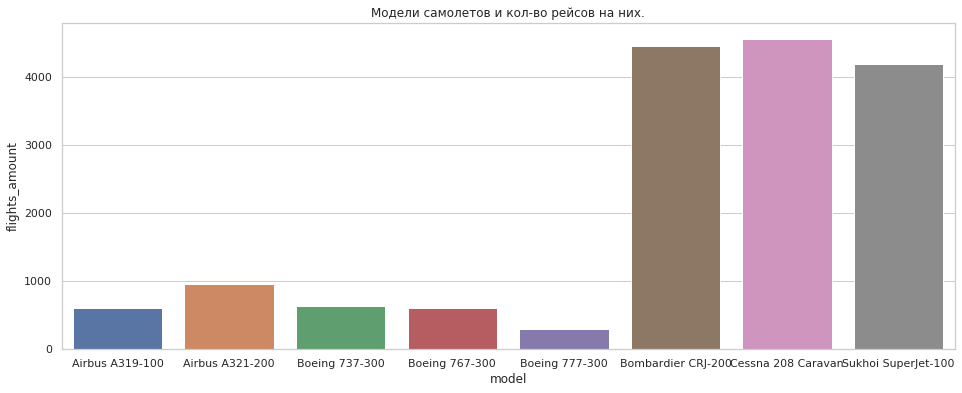

In [8]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="model", y="flights_amount", data=model_flights).set_title('Модели самолетов и кол-во рейсов на них.')

Количество рейсов на *Bombardier CRJ-200*, *Cessna 208 Caravan*, *Sukhoi SuperJet-100* по отдельности больше суммы рейсов на всех самолетах компании *Airbus* или *Boeing*. Все самолеты кроме *Sukhoi* были разработаны в 80-90 годах, но этот фактор не выглядит сильно влияющим на кол-во рейсов. Более четкие выводы можно получить, только изучив предметную область российских авиаперевозок.

Построим график, где будут изображены города и количество рейсов.

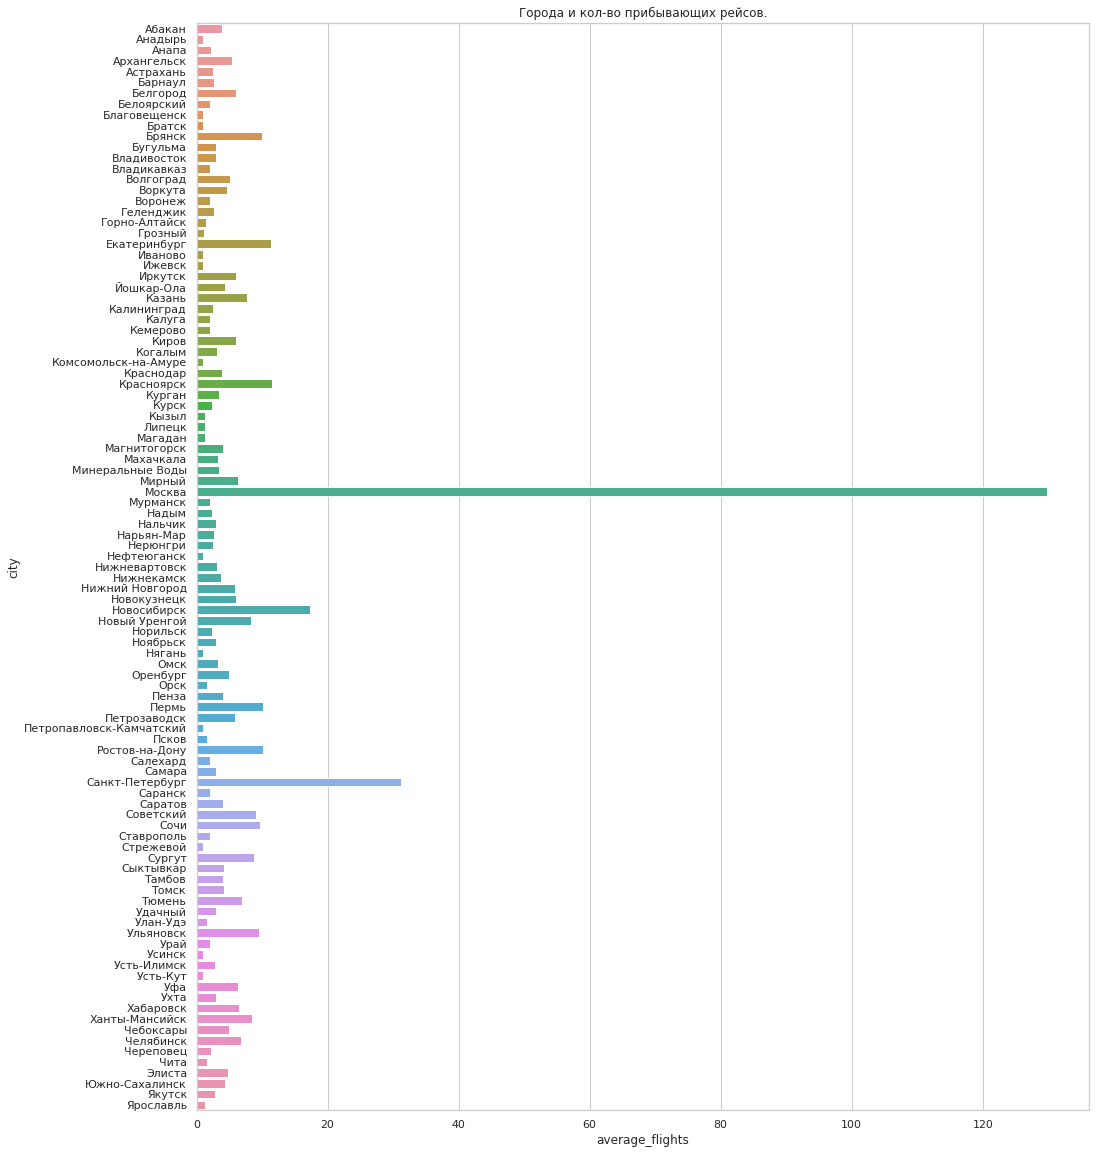

In [9]:
plt.figure(figsize=(16, 20))
sns.set(style="whitegrid")
ax = sns.barplot(x="average_flights", y="city", data=city_flights).set_title('Города и кол-во прибывающих рейсов.')

Больше всех выделяется столица, в крупных городах сравнительно одинаковое количество рейсов, в менее крупных в 2-3 раза меньше.

Построим график, где будут изображены топ-10 городов и количество рейсов.

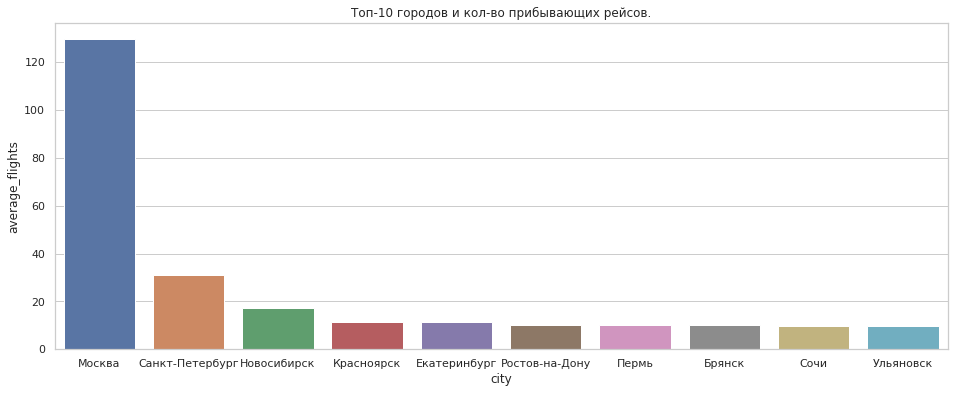

In [10]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="city", y="average_flights", data=max_flights_cities).set_title('Топ-10 городов и кол-во прибывающих рейсов.')

Москва опережает большинство городов в 7-12 раз. В крупных городах сравнительно одинаковое кол-во рейсов. Петербург как северная столица и важный деловой город стоит особняком - в нем количество рейсов в 2 раза больше чем в крупных городах, но все равно в разы меньше чем в Москве.

### Вывод

Мы осмотрели данные и проанализировали их. Время проверять гипотезу.

# 2. Проверка гипотезы <a class="anchor" id="2"></a>

Прочитаем файл, датафрейм сохраним в переменные:

In [11]:
# <Читаем файл из csv и сохраняем в переменную>
week_ticket = pd.read_csv('/datasets/query_last.csv')

Рассмотрим информацию о датафрейме и все его 10 строк:

In [12]:
# <рассмотрим таблицу week_ticket>
print(week_ticket.info())
week_ticket

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
week_number      10 non-null int64
ticket_amount    10 non-null int64
festival_week    3 non-null float64
festival_name    3 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes
None


,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Создадим *Series* с количеством билетов во время фестивалей, и в обычное время.

In [13]:
week_ticket_festival = week_ticket.query('festival_name.notnull()', engine='python')['ticket_amount']

In [14]:
week_ticket_nofestival = week_ticket.query('festival_name.isnull()', engine='python')['ticket_amount']

Проверим гипотезу: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время». 

Сформулируем нулевую и альтернативную гипотезы:

**H₀:** Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время

**H₁:** Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время

Попробуем критерий Манна-Уитни:

In [15]:
# <Уровень значимости>
alpha = 0.05

# <Метод библиотеки scipy, позволяющий проверить гипотезу о равенстве двух средних>
results =  st.mannwhitneyu(
    week_ticket_festival, 
    week_ticket_nofestival,alternative='two-sided')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.06824748837800128
Не получилось отвергнуть нулевую гипотезу


В документации к методу сказано что *None* в аргументе *alternative* нужен для обратной совместимости и не рекомендуется. *Greater* и *Less* не подходят, тест двухсторонний, так как нам не важно больше среднее или меньше. Потому *two-sided*.

Нулевая гипотеза не отвергается. В самом деле кол-во билетов во время фестивалей, и в обычное время не сильно отличается

In [16]:
print(week_ticket_festival.mean())
print(week_ticket_nofestival.mean())

48662.666666666664
51530.857142857145


Попробуем критерий Стьюдента:

In [17]:
# <Уровень значимости>
alpha = 0.05

# <Метод библиотеки scipy, позволяющий проверить гипотезу о равенстве двух средних>
results =  st.ttest_ind(
    week_ticket_festival, 
    week_ticket_nofestival)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.09688869045922928
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергается. В самом деле кол-во билетов во время фестивалей, и в обычное время не сильно отличается

- Как вы формулировали нулевую и альтернативную гипотезы;

Нулевая гипотеза - мы предполагаем что средние равны, альтернативная - что нет.

- Какой критерий использовали для проверки гипотез и почему.

Я использовал *U-критерий Манна — Уитни* и *t-критерий Стьюдента*, первый подходит для малых выборок, но у нас их еще меньше чем нужно для этого теста. Второй использовал так как это критерий для проверки равенства средних для двух независимых выборок.

### Вывод

Мы удостоверились с помощью критерия Манна-Уитни что средние не сильно отличаются. Но стоит заметить - наши выборки слишком малы. Но проверять на таком количестве данных гипотезы можно. Цитата из Википедии про критерий Манна-Уитни: "В каждой из выборок должно быть не менее 3 значений признака.". Нам это подходит.

# 3. Общий вывод <a class="anchor" id="3"></a>

Мы подтянули SQL-запросы, построение графиков и проверку гипотез, это отличная тренировка, которая позволяет не забывать полученные в курсе навыки.